(330, 3)
330
(265, 3)
595
(339, 3)
934
(353, 3)
1287
(367, 3)
1654
(574, 3)
2228
(430, 3)
2658
isao
[[ 0.010997  0.        0.      ]
 [ 0.02008   0.        0.      ]
 [ 0.029922  1.        0.      ]
 ...
 [ 4.280133 -3.        6.      ]
 [ 4.290071 -3.        6.      ]
 [ 4.300049 -3.        6.      ]]
(2658, 3)
(296, 3)
296
(292, 3)
588
(292, 3)
880
(242, 3)
1122
(251, 3)
1373
(216, 3)
1589
(219, 3)
1808
(245, 3)
2053
(266, 3)
2319
(264, 3)
2583
(246, 3)
2829
(265, 3)
3094
(239, 3)
3333
(220, 3)
3553
(222, 3)
3775
(257, 3)
4032
(226, 3)
4258
(231, 3)
4489
(253, 3)
4742
(239, 3)
4981
hisashi
[[ 0.009964  0.        0.      ]
 [ 0.019938  1.        1.      ]
 [ 0.029911  1.        1.      ]
 ...
 [ 2.370829 -6.       -2.      ]
 [ 2.380804 -7.       -1.      ]
 [ 2.390781 -7.       -1.      ]]
(4981, 3)
(7639, 1)
(7639, 1)
(7639, 2)
(3328, 2)
(1648, 2)
(2663, 2)
(3328, 2)
(1648, 2)
(2658, 2)
6.074e-02
0 0.0014396074519009512
3 0.002796446575873715
4 0.003968374121584281
5 0.0058249048662

C:\Users\gouhe\AppData\Local\Temp\ipykernel_21440\2407284695.py:194: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.2)


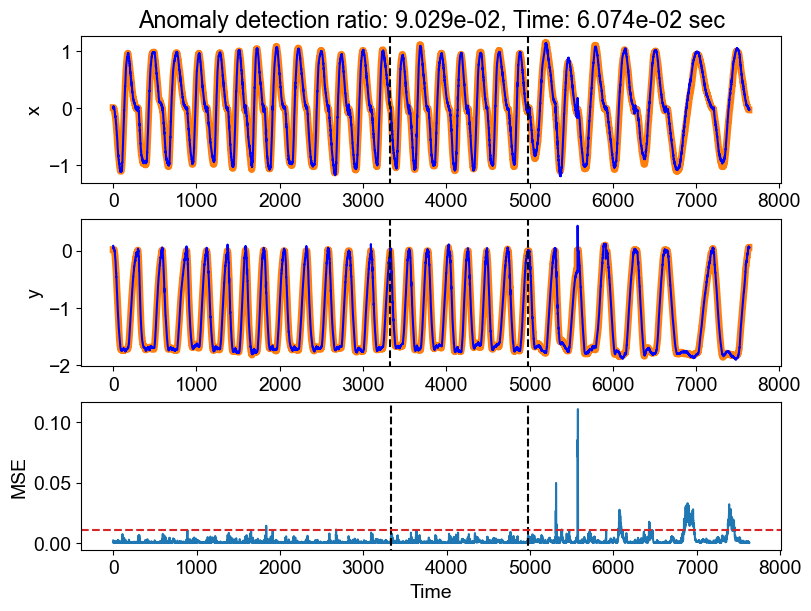

In [40]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

########################################
# LSTM anomaly detection for handwritten data
# (c) Gouhei Tanaka
########################################

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import time

from sklearn.preprocessing import StandardScaler

import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

from scipy import optimize

from model import ESN, Tikhonov, Pseudoinv

if __name__ == '__main__':

    # read data (InoueI)
    data_i = np.empty([0,3])
    count_i = 0
    for n in range(7):
        df = pd.read_csv('./InoueI/inouei_'+str(n)+'.csv', header=0, delimiter=',')
        print(df.shape)
        count_i += df.shape[0]
        print(count_i)
        data_i = np.vstack((data_i, df))
    print('isao')
    print(data_i)
    print(data_i.shape)

    data_i_x = data_i[:,1]/100
    data_i_x = data_i_x.reshape(len(data_i_x), -1)
    data_i_y = data_i[:,2]/100
    data_i_y = data_i_y.reshape(len(data_i_y), -1)

    #scaler = StandardScaler()
    #std_data_i_x = scaler.fit_transform(data_i_x)
    #std_data_i_y = scaler.fit_transform(data_i_y)

    # read data (InoueH)
    data_h = np.empty([0,3])
    count_h = 0
    for n in range(20):
        df = pd.read_csv('./InoueH/inoueH_'+str(n)+'.csv', header=0, delimiter=',')
        print(df.shape)
        count_h += df.shape[0]
        print(count_h)
        data_h = np.vstack((data_h, df))
    print('hisashi')
    print(data_h)
    print(data_h.shape)

    data_h_x = data_h[:,1]/100
    data_h_x = data_h_x.reshape(len(data_h_x), -1)
    data_h_y = data_h[:,2]/100
    data_h_y = data_h_y.reshape(len(data_h_y), -1)

    #scaler = StandardScaler()
    #std_data_h_x = scaler.fit_transform(data_h_x)
    #std_data_h_y = scaler.fit_transform(data_h_y)

    # concatenate two data without scaling
    data_x = np.concatenate((data_h_x, data_i_x))
    data_y = np.concatenate((data_h_y, data_i_y))
    print(data_x.shape)
    print(data_y.shape)

    # all data
    '''
    index_min = 0
    index_max = count_i +  count_h
    lookback = 400
    pred_len = 1

    U = np.empty([index_max-index_min-lookback-pred_len,0], dtype=float)
    D = np.empty([index_max-index_min-lookback-pred_len,0], dtype=float)

    for i in range(lookback):
        data_x_tmp = data_x[index_min+i:index_max-pred_len-lookback+i].reshape(-1,1)
        data_y_tmp = data_y[index_min+i:index_max-pred_len-lookback+i].reshape(-1,1)
        U = np.concatenate([U, data_x_tmp, data_y_tmp], axis=1)

    for j in range(pred_len):
        data_x_tmp = data_x[index_min+lookback+j:index_max-pred_len+j].reshape(-1,1)
        data_y_tmp = data_y[index_min+lookback+j:index_max-pred_len+j].reshape(-1,1)
        D = np.concatenate([D, data_x_tmp, data_y_tmp], axis=1)
    '''
    index_min = 0
    index_max = count_i +  count_h
    lookback = 0
    pred_len = 5
    
    #U = np.empty([index_max-index_min-lookback-pred_len,0], dtype=float)
    data = np.hstack([data_x, data_y])
    print(data.shape)
    
    len_train = 3333-pred_len
    len_val = count_h-3333
    len_test = data.shape[0]-len_train-len_val

    
    # 学習・テスト用情報
    U_train = data[0:len_train,:]
    U_val = data[len_train:len_train+len_val:]
    U_test = data[len_train+len_val:len_train+len_val+len_test,:]
    D_train = data[pred_len:len_train+pred_len,:]
    D_val = data[len_train+pred_len:len_train+len_val+pred_len,:]
    D_test = data[len_train+len_val+pred_len:len_train+len_val+len_test+pred_len,:]

    D = np.vstack((D_train, D_val))
    D = np.vstack((D, D_test))
    
    print(U_train.shape)
    print(U_val.shape)
    print(U_test.shape)
    print(D_train.shape)
    print(D_val.shape)
    print(D_test.shape)

    # ESNモデルの設定
    N_x = 20  # リザバーの大きさ
    model = ESN(U_train.shape[1], D_train.shape[1], N_x, density=0.05, input_scale=1.0, rho=0.9)
    
    # 学習
    time_start = time.time()
    model.train(U_train, D_train, Tikhonov(N_x, D_train.shape[1], 1e-5))
    #model.train(U_train, D_train, Pseudoinv(N_x, D_train.shape[1]))
    time_end = time.time()
    time_learning = time_end-time_start
    time_learning = '{0:.3e}'.format(time_learning)
    print(time_learning)
    
    # 検証データに対する予測と誤差
    Y_train = model.predict(U_train)
    Y_val = model.predict(U_val)
    Y_test = model.predict(U_test)
    Y = np.vstack((Y_train, Y_val))
    Y = np.vstack((Y, Y_test))
    #print(Y)

    mse_all = []
    rmse_all = []
    mae_all = []
    for i in range(D.shape[0]):
        mse = ((D[i,0] - Y[i,0])**2+(D[i,1]-Y[i,1])**2)/2
        mse_all.append(mse)
        rmse_all.append(np.sqrt(mse))
        mae_all.append(np.abs(D[i,0] - Y[i,0]))


    mse_val = []
    rmse_val = []
    mae_val = []
    mse_val_max = 0.0
    for i in range(D_val.shape[0]):
        mse = ((D_val[i,0] - Y_val[i,0])**2+(D_val[i,1]-Y_val[i,1])**2)/2
        mse_val.append(mse)
        rmse_val.append(np.sqrt(mse))
        mae_val.append(np.abs(D_val[i,0] - Y_val[i,0]))
        if mse > mse_val_max:
            mse_val_max = mse
            print(i, mse_val_max)

    mse_test = []
    rmse_test = []
    mae_test = []
    count_a = 0
    for i in range(D_test.shape[0]):
        mse = ((D_test[i,0] - Y_test[i,0])**2+(D_test[i,1]-Y_test[i,1])**2)/2
        mse_test.append(mse)
        rmse_test.append(np.sqrt(mse))
        mae_test.append(np.abs(D_test[i,0] - Y_test[i,0]))
        if mse >= mse_val_max:
            count_a += 1
    adr = count_a/D_test.shape[0]
    adr = '{0:.3e}'.format(adr)
    print('Anomaly detection ratio=', adr)
    
    # draw
    plt.rcParams['font.size'] = 14
    plt.rcParams['font.family'] = 'Arial'
    fig, ax = plt.subplots(3, 1, figsize=(8,6), constrained_layout=True)
    plt.subplots_adjust(hspace=0.2)

    ax[0].plot(D[:,0], color='tab:orange', linewidth=5, label = 'Target')
    ax[0].plot(Y[:,0], color='blue', label = 'Prediction')
    ax[0].axvline(x=len_train, ymin=-1, ymax=1, linestyle='--', color='black')
    ax[0].axvline(x=len_train+len_val, ymin=-1, ymax=1, linestyle='--', color='black')
    ax[0].set_ylabel('x')
    ax[0].set_title('Anomaly detection ratio: '+str(adr)+', Time: '+str(time_learning)+' sec')
    #ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    #ax[0].legend(loc='best')

    ax[1].plot(D[:,1], color='tab:orange', linewidth=5, label = 'Target')
    ax[1].plot(Y[:,1], color='blue', label = 'Prediction')
    ax[1].axvline(x=len_train, ymin=-2, ymax=1, linestyle='--', color='black')
    ax[1].axvline(x=len_train+len_val, ymin=-2, ymax=1, linestyle='--', color='black')
    ax[1].set_ylabel('y')
    #ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    #ax[1].legend(loc='best')

    ax[2].plot(mse_all, '-')
    #ax[2].plot(mae_all, label='MAE')
    #ax[2].plot(rmse_all, label='RMSE')
    ax[2].set_ylabel('MSE')
    #ax[2].set_ylim([0, 0.02])
    ax[2].axvline(x=len_train, ymin=-2, ymax=1, linestyle='--', color='black')
    ax[2].axvline(x=len_train+len_val, ymin=-2, ymax=1, linestyle='--', color='black')
    #ax[2].axvline(x=3333+1390, ymin=-2, ymax=1, linestyle='--', color='tab:pink')
    ax[2].axhline(y=mse_val_max, xmin=0, xmax=D.shape[0], linestyle='--', color='tab:red')
    ax[2].set_xlabel('Time')

    #plt.show()
    plt.savefig('test_ts.eps', bbox_inches="tight")
    plt.savefig('test_ts.png', bbox_inches="tight")
